In [13]:
import time
import cv2 as cv
import mediapipe as mp
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from models.hand_gesture import HandGesture
from models.hand_gesture import normalized_landmarks, landmark_bbox
from models.character_recognize import CharacterRecognize

In [14]:
PATH = 'data/videos/test.mp4'
GESTURE_MODEL_PATH = 'models/hand_gesture_model.pth'
CHARACTER_MODEL_PATH = 'models/character_recognizer_model.pth'

In [15]:
def position_scaler(points):  # scales to 28*28 pixel
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]

    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)

    scaled_points = []
    for x, y in points:  # 4 to 25
        scaled_x = 4 + ((x - min_x) * (22 - 1)) // (max_x - min_x)
        scaled_y = 4 + ((y - min_y) * (22 - 1)) // (max_y - min_y)
        scaled_points.append((scaled_x, scaled_y))
    return scaled_points


points = [(14, 15), (70, 70), (48, 12)]
print(position_scaler(points))

[(4, 5), (25, 25), (16, 4)]


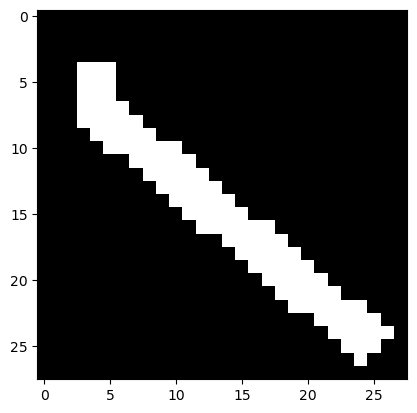

In [16]:
def position_to_image(positions):  # positions to 28*28 image
    positions = position_scaler(positions)
    image_size = (28, 28)
    image = Image.new("L", image_size, color="black")
    draw = ImageDraw.Draw(image)
    for i in range(1, len(positions)):
        x1, y1 = positions[i - 1]
        x2, y2 = positions[i]
        draw.line([(x1, y1), (x2, y2)], width=3, fill="white")
    return image


image = position_to_image([(1, 3), (5, 20), (140, 120)])
plt.imshow(image, cmap='grey')

clench set


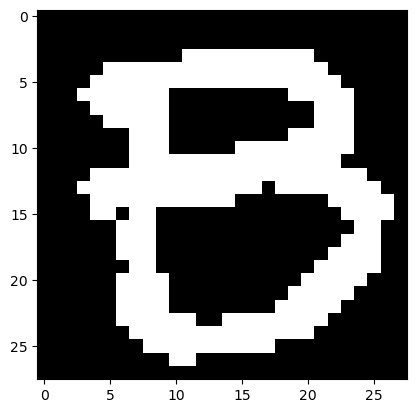

B
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clench set


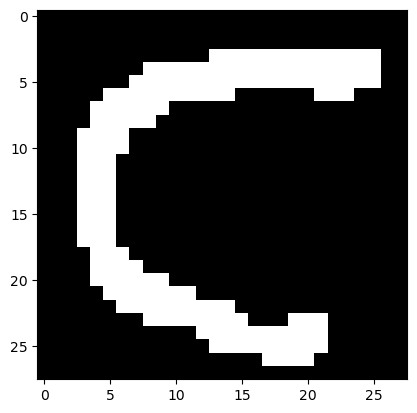

C
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clench set


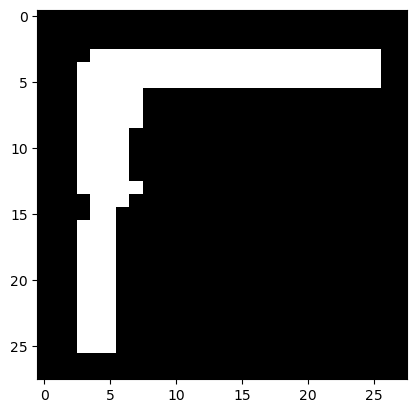

T
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
open palm for 2 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clench set


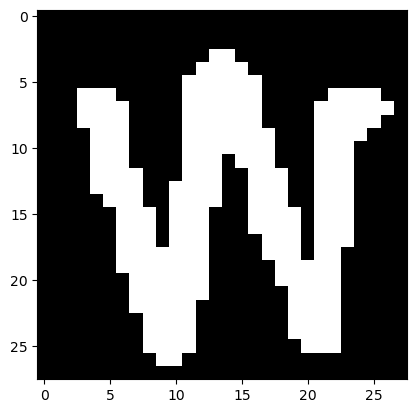

W
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clenched fist for 0.5 seconds!
clench set
clench set


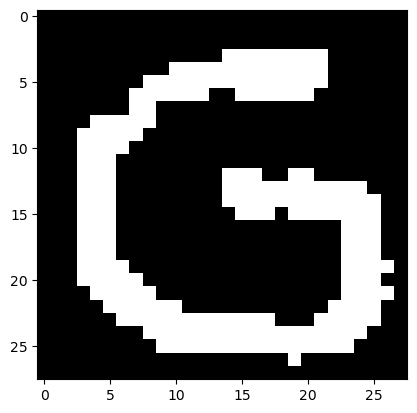

G
clenched fist for 0.5 seconds!
clench set


In [17]:
video = cv.VideoCapture(PATH)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

Trail = []
gesture_recognizer = HandGesture(GESTURE_MODEL_PATH)
character_recognizer = CharacterRecognize(CHARACTER_MODEL_PATH)

clenched_fist_timer = None
open_palm_timer = None
while video.isOpened():
    ret, frame = video.read()
    ret, frame = video.read()
    ret, frame = video.read()

    if ret:

        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        H, W, _ = frame.shape
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                position = normalized_landmarks(hand_landmarks, H, W)
                pred, confidence = gesture_recognizer.predict(position)
                pred = pred.replace('_', ' ')
                if pred == 'index finger up' and confidence > 0.99:
                    index_finger = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP]
                    cx, cy = int(index_finger.x * W), int(index_finger.y * H)
                    Trail.append((cx, cy))

                elif pred == 'clenched fist' and confidence > 0.98:
                    if clenched_fist_timer is None:
                        print('clench set')
                        clenched_fist_timer = time.time()
                    elif time.time() - clenched_fist_timer > 0.5:
                        if Trail:
                            image = position_to_image(Trail)
                            plt.imshow(image, cmap='grey')
                            character_pred = character_recognizer.predict(image)
                            plt.show()
                            print(character_pred[0])

                        clenched_fist_timer = None
                        print('clenched fist for 0.5 seconds!')
                        Trail = []

                elif pred == 'open palm' and confidence > 0.98:
                    if open_palm_timer is None:
                        open_palm_timer = time.time()
                    elif time.time() - open_palm_timer > 2:
                        open_palm_timer = None
                        print('open palm for 2 seconds!')
                        Trail = []

                # reset timers 
                if pred != 'clenched fist': clenched_fist_timer = None
                if pred != 'open palm': open_palm_timer = None

                x1, y1, x2, y2 = landmark_bbox(hand_landmarks, H, W)
                cv.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 4)
                cv.putText(frame, f'{pred} | confidence : {confidence:0.3}', (int(x1), int(y1)),
                           cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv.LINE_AA)

                # mp_drawing.draw_landmarks(
                # frame,
                # hand_landmarks,
                # mp_hands.HAND_CONNECTIONS,  
                # mp_drawing_styles.get_default_hand_landmarks_style(),
                # mp_drawing_styles.get_default_hand_connections_style())

        for i in Trail:
            cv.circle(frame, i, 10, (0, 255, 0), cv.FILLED)
        cv.imshow('frame', frame)

        if cv.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()